In [15]:
import numpy as np
from scipy import constants

%load_ext autoreload
%autoreload 2

from sentinel1Etad import Sentinel1Etad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
file='test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE'
eta_ = Sentinel1Etad(file)

In [17]:
#check what are the correction performed
eta_.processing_setting()

{'troposphericDelayCorrection': True,
 'ionosphericDelayCorrection': True,
 'solidEarthTideCorrection': True,
 'bistaticAzimuthCorrection': True,
 'dopplerShiftRangeCorrection': True,
 'FMMismatchAzimuthCorrection': True}

In [18]:
#burst catalogue computed from the XML annotations
# it is a pandas dataframe to allow easy filtering
eta_.burst_catalogue.head()


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
3,10,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
4,13,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229


# Use cases for the Sentinel1Etad class

## Use case 1 : Selecting the bursts

### Selecting the burst by filtering in time

Once the burst catalogue is availble,
it is possible to filter the burst by performing time selection using the __first_time__ and __last_time__ keywords of the __query_burst__ method.

In [19]:
#Example of filtering by time
# it gives all the burst
from dateutil import parser

#if no time is provided then all the burst are selected
df = eta_.query_burst()

print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 27


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671


In [20]:
#it is possible to reduce the selection by  start time
#in this case the stop time is the last available burst
first_time = parser.parse('2019-08-05T16:25:30.117898')
df = eta_.query_burst(first_time=first_time)
print(f"Number of bursts: {len(df)}")
df.head()


Number of bursts: 4


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
25,24,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:31.017231,2019-08-05 16:25:34.240344
8,25,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:31.880565,2019-08-05 16:25:35.046122
17,26,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:32.830232,2019-08-05 16:25:36.024566
26,27,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:33.779899,2019-08-05 16:25:36.974233


In [21]:
#it is possible to reduce the selection by the stop time
#in this case the start time is the first available burst
last_time =  parser.parse('2019-08-05T16:25:20.117899')
df = eta_.query_burst(last_time=last_time)
print(f"Number of bursts: {len(df)}")
df.head()


Number of bursts: 8


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671


In [22]:
#it is possible to reduce the selection by the start and stop time
first_time = parser.parse('2019-08-05T16:25:25.117898')
last_time =  parser.parse('2019-08-05T16:25:29.117899')

#query the catalogues for of all the swaths
df = eta_.query_burst(first_time=first_time, last_time=last_time)
print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 1


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
23,18,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:25.520674,2019-08-05 16:25:28.715008


### Selecting by swath (and time)
The time selection can be combined with a selection by swath using the __swath__ keyword.
If not used all the swath are used

In [23]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

#query the catalogue for a subset of the swaths
df = eta_.query_burst(first_time=first_time, last_time=last_time, swath='IW1')
print(f"Number of bursts: {len(df)}")
df

Number of bursts: 9


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893
3,10,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:18.096004,2019-08-05 16:25:21.261561
4,13,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:20.858672,2019-08-05 16:25:24.024229
5,16,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:23.621340,2019-08-05 16:25:26.786896
6,19,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:26.355230,2019-08-05 16:25:29.549564
7,22,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:29.117897,2019-08-05 16:25:32.283454
8,25,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:31.880565,2019-08-05 16:25:35.046122


In [24]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

#query the catalogue for a subset of the swaths
df = eta_.query_burst(first_time=first_time, last_time=last_time, swath=['IW1', 'IW2'])
print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 18


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
0,1,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:09.836779,2019-08-05 16:25:13.002336
9,2,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:10.757668,2019-08-05 16:25:13.952003
1,4,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:12.570669,2019-08-05 16:25:15.736226
10,5,1,2,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW2,2019-08-05 16:25:13.520336,2019-08-05 16:25:16.714671
2,7,1,1,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW1,2019-08-05 16:25:15.333337,2019-08-05 16:25:18.498893


### Selecting by Sentinel-1 product name (swath and time)
The time selection can be combined with a selection by swath using the __product_name__ keyword.


In [25]:
first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

#query the catalogue for a subset of the swaths
product_name='S1B_IW_SLC__1SDV_20190805T162509_20190805T162536_017453_020D3A_AAAA.SAFE'
df = eta_.query_burst(first_time=first_time, last_time=last_time, product_name=product_name, swath=['IW3'])
print(f"Number of bursts: {len(df)}")
df.head()

Number of bursts: 9


,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
18,3,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:11.736113,2019-08-05 16:25:14.930448
19,6,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:14.470003,2019-08-05 16:25:17.693115
20,9,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:17.232671,2019-08-05 16:25:20.427005
21,12,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:19.995338,2019-08-05 16:25:23.189673
22,15,1,3,S1B_IW_SLC__1ADV_20190805T162509_20190805T1625...,IW3,2019-08-05 16:25:22.758006,2019-08-05 16:25:25.952341


## Use case 2 : Retrieving the corrections
The Sentinel1Etad Class allows to access the netcdf product to retrieve the corrections burst by burst
```
    def get_tropospheric_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_ionospheric_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_geodetic_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_bistatic_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_doppler_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_fmrate_correction(self, set_auto_mask=False, transpose=True, meter=False):
    
    def get_sum_correction(self, set_auto_mask=False, transpose=True, meter=False):
```

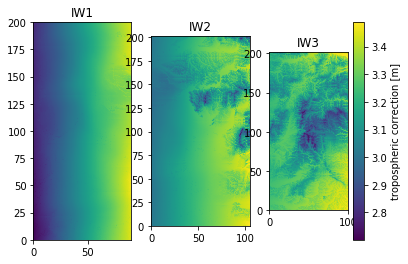

In [26]:
#First select you burst
import matplotlib.pyplot as plt

first_time = parser.parse('2019-08-05T16:25:00.117898')
last_time =  parser.parse('2019-08-05T16:25:40.117899')

#query the catalogue for a subset of the swaths
product_name='S1B_IW_SLC__1SDV_20190805T162509_20190805T162536_017453_020D3A_AAAA.SAFE'
df = eta_.query_burst(first_time=first_time, last_time=last_time, product_name=product_name)

#iterate appropriatly to get the correction desired and concatenate them
fig, ax = plt.subplots(nrows=1, ncols=len(df.swathID.unique() ))

for six, swath_ in enumerate(df.swathID.unique()):
    #for each swath get the burst index of each swath
    burst_index_list = df.bIndex[df.swathID==swath_].values
    
    #read the netcdf group for the requested swath using the indexing operator[]
    swath_dataset = eta_[swath_]

    for b, burst_index in enumerate(burst_index_list):
        
        #read the netcdf group for the requested burst using the indexing operator[] with the right burst index
        burst_dataset = swath_dataset[burst_index]
        #get the correction wanted in meters
        # it returns a dict
        tropo_correction = burst_dataset.get_tropospheric_correction(meter=True)
        
        #concatenate
        #Note that the concatenation is not correct as it doesn't take into account the burst overlap
        if b == 0:
            tropo_correction_all = tropo_correction['x']
        else:
            tropo_correction_all = np.concatenate((tropo_correction_all, tropo_correction['x']) )
 
          # the get_tropospheric_correction tranpose the array as coded in NC

    ysize, xsize = tropo_correction_all.shape

    grid_spacing = eta_.grid_spacing
    x_axis = np.arange(xsize)*grid_spacing['x']/1000
    y_axis = np.arange(ysize)*grid_spacing['y']/1000      

    im = ax[six].imshow(tropo_correction_all,extent=[x_axis[0],x_axis[-1], y_axis[0], y_axis[-1]],)
    ax[six].set_title(swath_)

fig.colorbar(im,label=f"{tropo_correction['name']} correction [{tropo_correction['unit']}]")
plt.show()
       

## Use case 3 : Retrieving the footprints

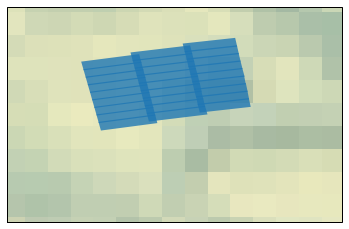

In [27]:
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, MultiPolygon


def tile_extent(poly, widen_area = 2):
    bb = list(poly.bounds)
    bb [1:3] = bb [2:0:-1]
    bb2 = np.asarray(bb)  + [-widen_area,widen_area,-widen_area,widen_area]
    return bb2


#get the footprints of the selected bursts
swath_polys =[ eta_[swath_].get_footprint() for swath_ in ['IW1', 'IW2', 'IW3'] ]


ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(itertools.chain(*swath_polys))))

# Put a background image on for nice sea rendering.
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
for polys in swath_polys:
    ax.add_geometries(polys,crs=ccrs.PlateCarree(), alpha=0.8)

plt.show()
